In [19]:
# /!\ Incomplete

<strong>ARIMA (AutoRegressive Integrated Moving Average)</strong> is a modelling method used in time series forecasting and involves three different procedures:
- Differencing the time series to reach "stationarity" (thus "integrated")
- Determining relevant past steps to predict the next time step ("autoregression")
- Determining ("moving average")

The last two processes are independently called AR model and MA model.

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from pmdarima.datasets import load_airpassengers
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

%matplotlib inline

In [2]:
# Import dataset
s = load_airpassengers(as_series=True)
dti = pd.date_range('1949-01-01', periods=s.shape[0], freq='M')
df = pd.DataFrame({'date': dti, 'passengers': s})
df.head()

,date,passengers
0,1949-01-31,112.0
1,1949-02-28,118.0
2,1949-03-31,132.0
3,1949-04-30,129.0
4,1949-05-31,121.0


/Users/sbcmac080/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


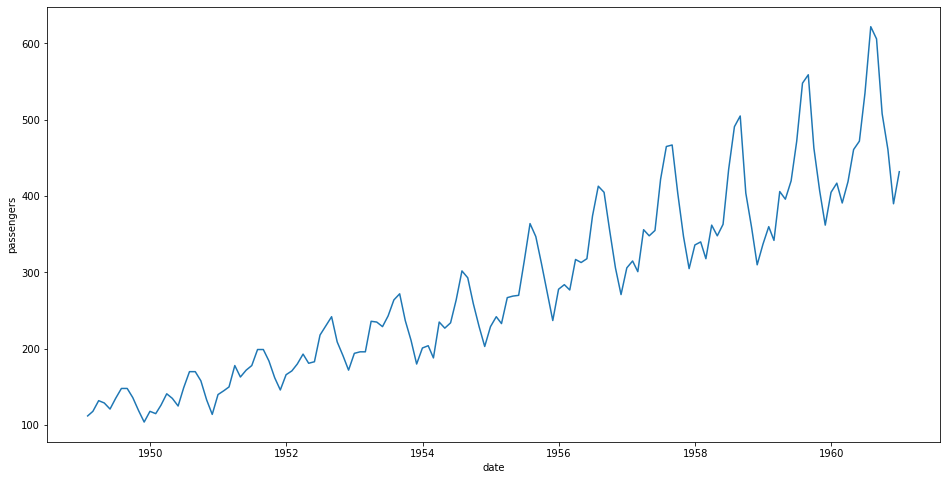

In [3]:
plt.figure(figsize=(16,8))
sns.lineplot(x='date', y='passengers', data=df)

We use the Box & Jenkins airline data, which records monthly totals of international airline passengers from 1949 to 1960.

## 0) Time series properties

A time series has several properties:
- <strong>level:</strong> the actual value of the time series
- <strong>trend:</strong> a tendency of the series to increase of decrease over time
- <strong>seasonality:</strong> change in the time series that occurs following regular time periods
- <strong>noise/error:</strong> the irregularities that arise from randomness and unforeseen events explaining potential outliers
- <strong>cycles:</strong> change in the time series that occurs with irregular time periods unlike seasonality (e.g. market)

We can decompose the time series into several of the above properties provided we specify values that we already know, such as the most plausible period the series follows (e.g. 12 months in a year), as well as whether the seasonality is "additive" or "multiplicative".<br><br>
The seasonality is additive if the level seems to behave independently from the trend, i.e. if the amplitude of the seasonality does not change even if the trend increases. The seasonality is multiplicative if the amplitude of the seasonality seems to behave proportionally to the trend. We observe a multiplicative seasonality in the series above considering the amplitude increases with th trend.<br><br>(Here is a great resource to visualize additive/multiplicative seasonality:<br> https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/)

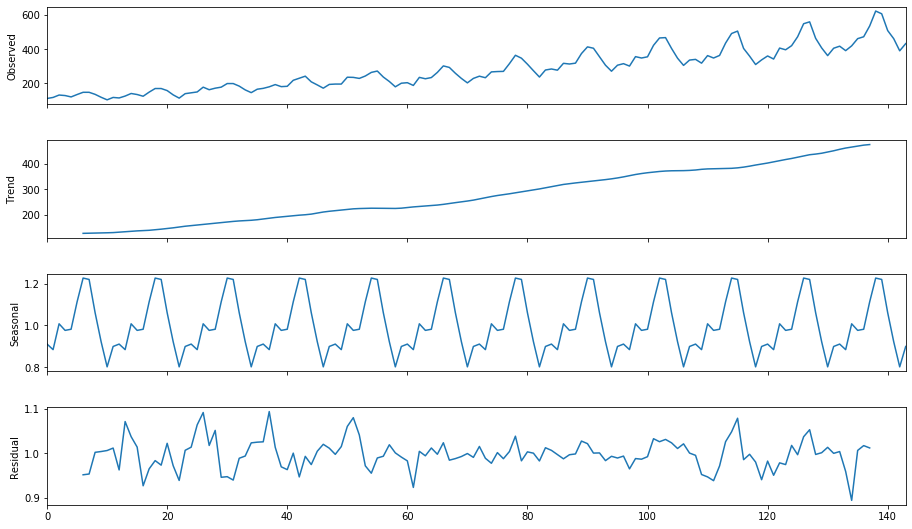

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['passengers'], model='multiplicative', freq=12)
fig = result.plot()
fig.set_size_inches(14, 8)

<u>Note</u>: Considering cyclic components other than seasonality are not obvious, we cannot extract them easily from the time series in the above decomposition.

## 1) Stationarity and differencing (AR\[I\]MA)

<strong>stationarity:</strong> A time series is stationary when its mean, variance and autocorrelation are all constant over time. <br><br>
Time series forecasting is based on the assumption that future values will reflect past values, and most methods therefore rely on stationarity of a given series. The first step in ARIMA requires us to identify whether the time series is stationary and if not, to transform it until it becomes stationary. This process is called "differencing".

### 1.1) Checking stationarity

One way to check stationarity is to do it visually:

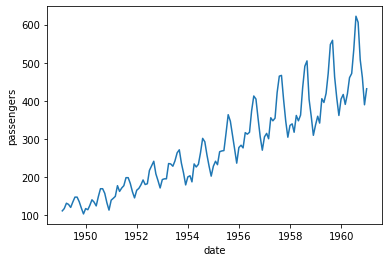

In [5]:
sns.lineplot(x='date', y='passengers', data=df)

The above plot suggests the mean and the variance increase over time so the time series is not stationary.

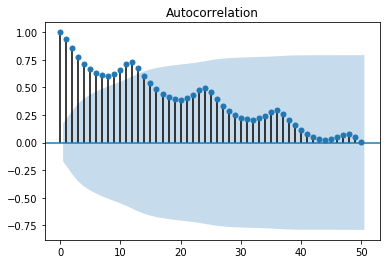

In [20]:
plot_acf(df['passengers'], lags=50)
plt.show()

We can use an autocorrelation plot to further check stationarity. The autocorrelation decays slowly and remains outside the 95% confidence range for many lags, which suggest the time series is non-stationary.

There exists different tests to check for stationarity and the Dickey-Fuller test is one them:

In [8]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['passengers'], autolag='AIC', maxlag=20)
tstat, pvalue, usedlag, nobs, critval, icbest = dftest
print("test-statistic: {}, critical value (1%): {}".format(tstat, critval['1%']))
if tstat < critval['1%']:
    print("T.S. likely to be stationary")
else:
    print("T.S. likely to be non-stationary")

test-statistic: 0.8153688792060423, critical value (1%): -3.4816817173418295
T.S. likely to be non-stationary


### 1.2) Differencing

Differencing consists in removing seasonality or trend in a time series by taking differences between values in the series.<br>
Differencing with a lag of 1 can for example help remove trend in the series.
Differencing with a lag of M where M is the number of seasons in the data can help remove seasonality.
Double diffencing is when we perform both differencing to remove both trend and seasonality.

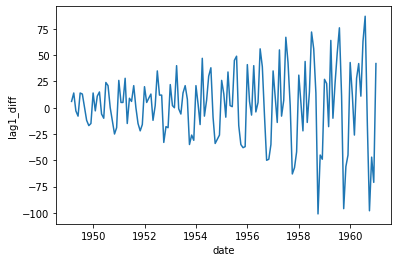

In [9]:
# Removing trend
df['lag1_diff'] = df['passengers'] - df['passengers'].shift(1)
sns.lineplot(x='date', y='lag1_diff', data=df)

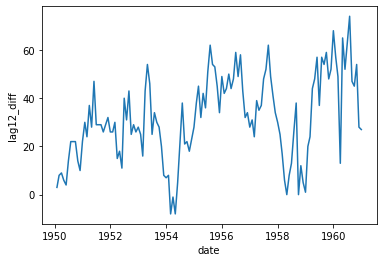

In [10]:
# Removing seasonality
df['lag12_diff'] = df['passengers'] - df['passengers'].shift(12)
sns.lineplot(x='date', y='lag12_diff', data=df)

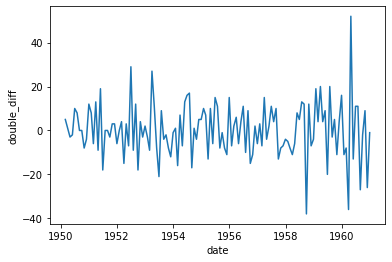

In [11]:
# Removing both seasonality and trend
first_diff = df['passengers'] - df['passengers'].shift(1)
df['double_diff'] = first_diff - first_diff.shift(12)
sns.lineplot(x='date', y='double_diff', data=df)

In [12]:
from statsmodels.tsa.stattools import adfuller
df = df.dropna(inplace=False)
dftest = adfuller(df['double_diff'], autolag='AIC', maxlag=20)
tstat, pvalue, usedlag, nobs, critval, icbest = dftest
print("test-statistic: {}, critical value (1%): {}".format(tstat, critval['1%']))
if tstat < critval['1%']:
    print("T.S. likely to be stationary")
else:
    print("T.S. likely to be non-stationary")

test-statistic: -15.59561808374634, critical value (1%): -3.4816817173418295
T.S. likely to be stationary


The Dickey-Fuller test returns a test-statistic and confidence threshold. When the test-statistic is smaller than the threshold (critical value), we can say the 

## 2) Partial autocorrelation and autoregression (\[AR\]IMA)

The autoregression (AR) component of ARIMA is a model that attempts to forecast the next value based on previous values. Now, the question we should ask is: How much do the previous steps help in predicting the next value, with seasonality and trend removed?

In [19]:
df.shape

(131, 5)

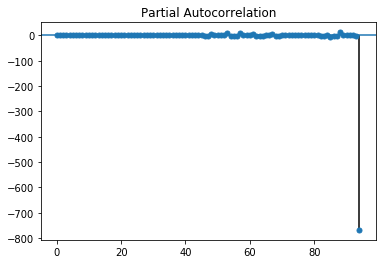

In [36]:
plot_pacf(df['double_diff'], lags=94)
plt.show()

## 3) Autocorrelation and Moving average (ARI\[MA\])

In [7]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from pmdarima.datasets import load_airpassengers

%matplotlib inline

In [8]:
# Import dataset
s = load_airpassengers(as_series=True)
dti = pd.date_range('1949-01-01', periods=s.shape[0], freq='M')
df = pd.DataFrame({'date': dti, 'passengers': s})
df.head()

,date,passengers
0,1949-01-31,112.0
1,1949-02-28,118.0
2,1949-03-31,132.0
3,1949-04-30,129.0
4,1949-05-31,121.0


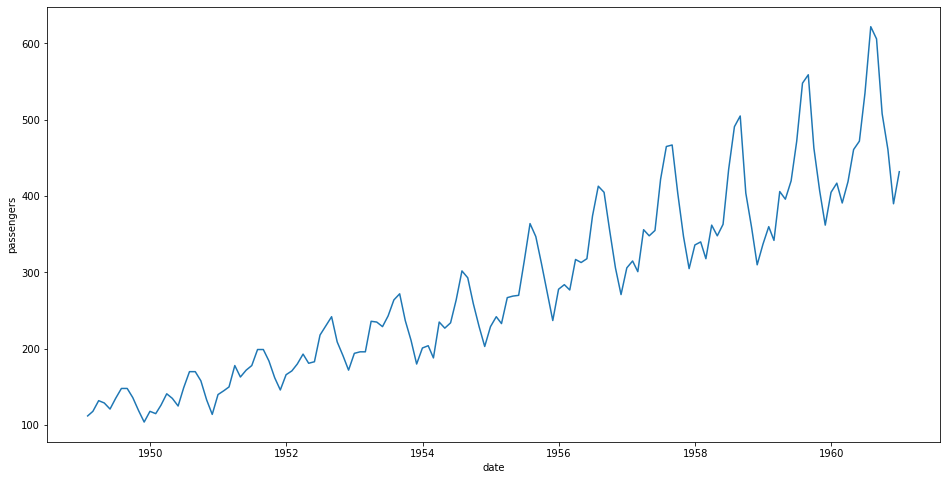

In [9]:
plt.figure(figsize=(16,8))
sns.lineplot(x='date', y='passengers', data=df)